# Interactive Plot to compare leaf contours and their feature space distances 
- Loads PCA model and dataset of leaf point clouds
- Creates two contour plots for comparison
- Use the textboxes to filter which leaf instances are shown (plant numbers, timesteps, or specific leaf numbers)
- Also plots a confusion matrix of the feature space distances between each instance pair


In [1]:
import leaf_encoding
import visualise
import organ_matching

%matplotlib notebook
from ipywidgets import *
import numpy as np
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Load data

In [2]:
train_ds, test_ds, train_labels, test_labels, pca, transformed = leaf_encoding.get_encoding()
sorted_data = train_ds[np.lexsort((train_labels[:,2], train_labels[:,1],train_labels[:,0])),:]
sorted_labels = train_labels[np.lexsort((train_labels[:,2], train_labels[:,1],train_labels[:,0])),:]

In [3]:
IDs = [0,3,None,0,4,None] # Plant, timestep, leafnr
annotations = 2 # 0 for plant number, 1 for timestep, 2 for leaf number

<IPython.core.display.Javascript object>


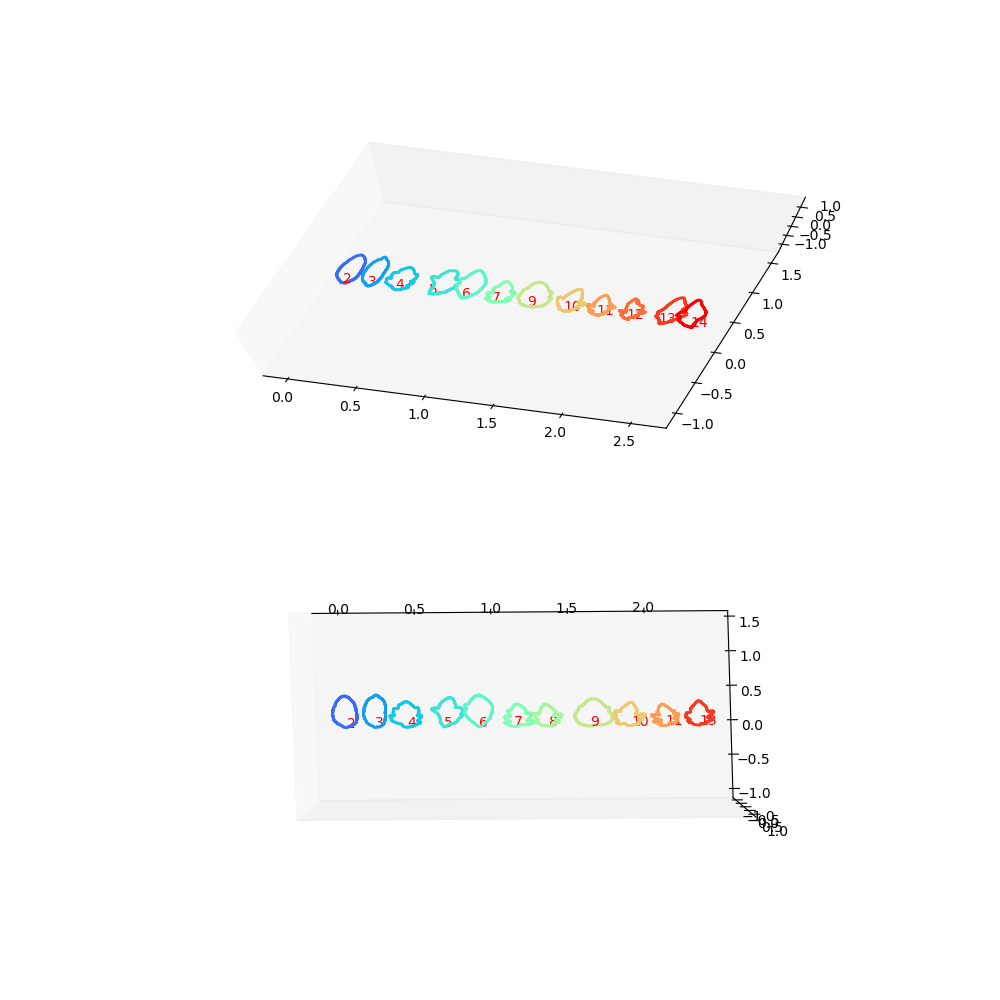

<IPython.core.display.Javascript object>


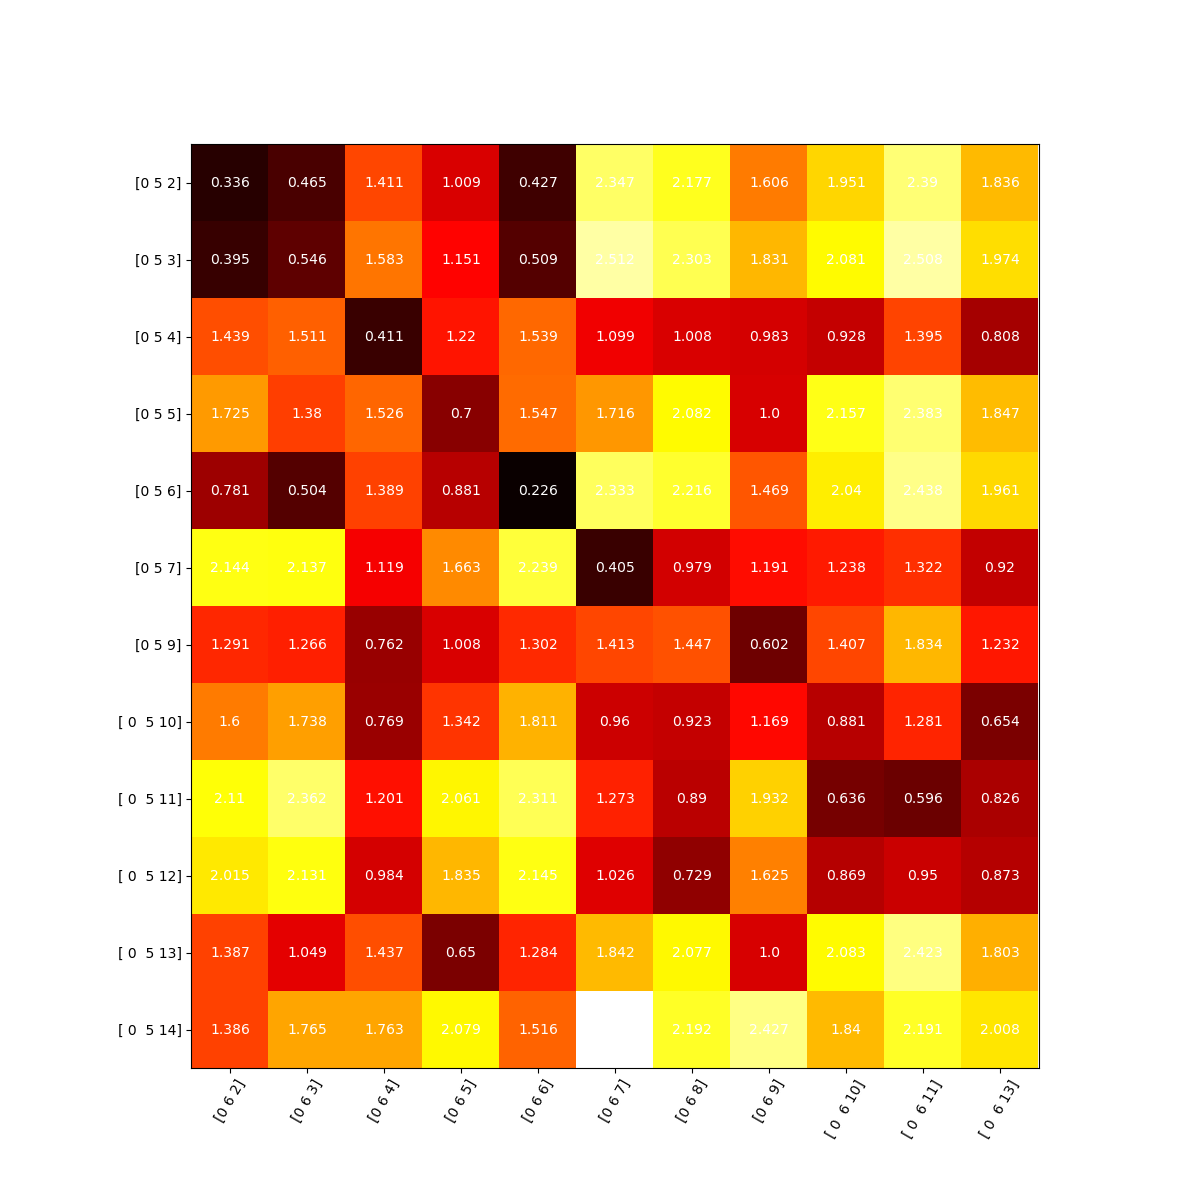

interactive(children=(Checkbox(value=True, description='box1'), BoundedIntText(value=0, description='Plant Num…

<function __main__.update(box1, plant, box2, timestep, box3, leaf, box4, plant2, box5, timestep2, box6, leaf2)>

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2, 1, 1, projection='3d')
ax2 = fig.add_subplot(2, 1, 2, projection='3d')
fig2 = plt.figure(figsize=(12, 12))
ax3 = fig2.add_subplot(1, 1, 1)
ax_3d = [ax,ax2]


def update(box1, plant, box2, timestep, box3, leaf, box4, plant2, box5, timestep2, box6, leaf2):
    toggles = [(box1, box2, box3), (box4, box5, box6)]
    parameters = [(plant, timestep, leaf), (plant2, timestep2, leaf2)]
    
    IDs = [[None if box == False else params[i] for i,box in enumerate(toggle)]for params,toggle in zip(parameters, toggles)]

    datasets = []
    for ID in IDs:
        subset, sub_labels = leaf_encoding.select_subset(sorted_data, sorted_labels, plant_nr = ID[0], timestep=ID[1], leaf=ID[2])
        datasets.append((subset,sub_labels))

    max_color = np.max((np.max(datasets[0][1][:,2]), np.max(datasets[1][1][:,2])))
    cmap = cm.get_cmap('rainbow')
    
    data_copy = copy.deepcopy(datasets)

    offset = True
    for subset, ax in zip(data_copy, ax_3d):
        ax.clear()
        ax.grid(False)
        #ax.axis('off')
        colours = cmap((subset[1][:,2]/max_color))
        cum_offset = 0
        width = 0
        for leaf,label,col in zip(subset[0],subset[1],colours):
            if offset:
                cum_offset += 0.6 * width
                width = (np.max(leaf[:,0]) - np.min(leaf[:,0]))
                cum_offset += 0.6 * width
                leaf[:,0] += cum_offset
            scatterplot = ax.scatter(xs=leaf[:,0], ys=leaf[:,1], zs=leaf[:,2], s=1, color=col)
            out = ax.text(leaf[0,0], leaf[0,1], leaf[0,2], s=str(label[annotations]), color='red')
        visualise.set_axes_equal(ax)
        
    ax3.clear()
    dist = organ_matching.make_dist_matrix(datasets[0][0], datasets[1][0], pca, draw=False, components=200)
    heatplot = organ_matching.plot_heatmap(dist, ax=ax3, show_values=True)
    out = heatplot.set_xticks(range(datasets[1][1][:].shape[0]))
    out = heatplot.set_yticks(range(datasets[0][1][:].shape[0]))
    out = heatplot.set_xticklabels(datasets[1][1][:], rotation = 60)
    out = heatplot.set_yticklabels(datasets[0][1][:])
    
    # get assignment via  Hunagrian Algorithm
    match, legible_matches = organ_matching.compute_assignment(dist, datasets[0][1], datasets[1][1])
    print(legible_matches)
    
    
    fig.canvas.draw_idle()
    fig2.canvas.draw_idle()

interact(update, \
         box1 = widgets.Checkbox(value=True), \
         plant = widgets.BoundedIntText(value=None, min=0, max=6, step=1, description='Plant Number'), \
         box2 = widgets.Checkbox(value=True), \
         timestep = widgets.BoundedIntText(value=None, min=0, max=10, step=1, description='time step'), \
         box3 = widgets.Checkbox(value=False), \
         leaf = widgets.BoundedIntText(value=None, min=2, max=40, step=1, description='leaf number'), \
         box4 = widgets.Checkbox(value=True), \
         plant2 = widgets.BoundedIntText(value=None, min=0, max=6, step=1, description='Plant Number'), \
         box5 = widgets.Checkbox(value=True), \
         timestep2 = widgets.BoundedIntText(value=None, min=0, max=10, step=1, description='time step'), \
         box6 = widgets.Checkbox(value=False), \
         leaf2 = widgets.BoundedIntText(value=None, min=2, max=40, step=1, description='leaf number'))

